### Authentication

In [ ]:
# from google.colab import auth, files
# from google.cloud import bigquery

# auth.authenticate_user()
# client = bigquery.Client(project='real-estate-ph-391212')

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

In [ ]:
# pip install pip install google-cloud-bigquery

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
key_path = '/Users/fuente/Documents/real_estate_ph_scoring/google_bq_service_account/real-estate-ph-391212-b99a0e22a14a.json'

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=['https://www.googleapis.com/auth/cloud-platform'],
)

from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

client = bigquery.Client(
    credentials=credentials,
    project='real-estate-ph-391212')

### BQ data pull

In [3]:
income = f"""

select * from `real-estate-ph-391212.production.avg_income`

"""

population = f"""

select * from `real-estate-ph-391212.production.avg_population`

"""

emp_rate = f"""

select * from `real-estate-ph-391212.production.employment_rate`

"""

gva = f"""

select * from `real-estate-ph-391212.production.gross_value_added`

"""


res_units_built = f"""

select * from `real-estate-ph-391212.production.residential_units_built`

"""


res_units_sold = f"""

select * from `real-estate-ph-391212.production.residential_units_sold`

"""

jobee = f"""

select * from `real-estate-ph-391212.production.jollibee_branches`

"""

city_coord = f"""

select * from `real-estate-ph-391212.production.city_coordinates`

"""

In [4]:
df_inc = client.query(income).to_dataframe()
df_pop = client.query(population).to_dataframe()
df_emp = client.query(emp_rate).to_dataframe()
df_gva = client.query(gva).to_dataframe()
df_rsb = client.query(res_units_built).to_dataframe()
df_rss = client.query(res_units_sold).to_dataframe()
df_jbe = client.query(jobee).to_dataframe()
df_map = client.query(city_coord).to_dataframe()

### Data processing

#### Jollibee branches

In [5]:
df_jbe.isna().value_counts()

region  region_id  province  provincial_id  city_municipality  city_municipality_id  no_of_branches
False   False      False     False          False              False                 False             1634
True    True       True      True           True               True                  True                 1
Name: count, dtype: int64

In [6]:
df_jbe.dropna(inplace=True)

In [7]:
df_jbe['no_of_branches'] = df_jbe['no_of_branches'].str.strip()
df_jbe['no_of_branches'] = df_jbe['no_of_branches'].replace('-',0)

#### City coordinates

In [9]:
df_map.isna().value_counts()

region  region_id  province  provincial_id  city_municipality  city_municipality_id  lat    long 
False   False      False     False          False              False                 False  False    1634
True    True       True      True           True               True                  True   True        1
Name: count, dtype: int64

In [10]:
df_map.dropna(inplace=True)

#### Avg. income

In [11]:
df_inc.isna().value_counts()

region  region_id  province  provincial_id  avg_income_2015  avg_income_2018  avg_income_2021
False   False      False     False          False            False            False              84
                                            True             False            False               1
Name: count, dtype: int64

In [12]:
df_inc[df_inc.isnull().any(axis=1)]

,region,region_id,province,provincial_id,avg_income_2015,avg_income_2018,avg_income_2021
25,region xi (davao region),rxi-001,davao occidental,davao-oc001,<NA>,25356,28511


In [13]:
df_inc[df_inc['region_id']=='rxi-001']

,region,region_id,province,provincial_id,avg_income_2015,avg_income_2018,avg_income_2021
25,region xi (davao region),rxi-001,davao occidental,davao-oc001,<NA>,25356,28511
26,region xi (davao region),rxi-001,davao del norte,dava-d-n001,23807,27034,27354
27,region xi (davao region),rxi-001,davao oriental,davao-or001,22889,26347,27806
28,region xi (davao region),rxi-001,davao de oro (compostela valley),dava-d-o001,22092,25867,26161
29,region xi (davao region),rxi-001,davao del sur,dava-d-s001,23215,25807,29749


In [14]:
df_inc[['avg_income_2015','avg_income_2018','avg_income_2021']] = df_inc[['avg_income_2015','avg_income_2018','avg_income_2021']].astype(float)

In [15]:
type(df_inc.at[25, 'avg_income_2015'])

numpy.float64

In [16]:
# Let's fill the null values with the average of the whole region

# Calculate the average income for region_id 'rxi-001'
avg_inc = df_inc[df_inc['region_id'] == 'rxi-001']['avg_income_2015'].mean()

# Fill missing values with the average income for davao occidental davao-oc001'
df_inc['avg_income_2015'].fillna(avg_inc, inplace=True)

In [17]:
df_inc[df_inc['region_id']=='rxi-001']

,region,region_id,province,provincial_id,avg_income_2015,avg_income_2018,avg_income_2021
25,region xi (davao region),rxi-001,davao occidental,davao-oc001,23000.75,25356.0,28511.0
26,region xi (davao region),rxi-001,davao del norte,dava-d-n001,23807.00,27034.0,27354.0
27,region xi (davao region),rxi-001,davao oriental,davao-or001,22889.00,26347.0,27806.0
28,region xi (davao region),rxi-001,davao de oro (compostela valley),dava-d-o001,22092.00,25867.0,26161.0
29,region xi (davao region),rxi-001,davao del sur,dava-d-s001,23215.00,25807.0,29749.0


#### Population

In [18]:
df_pop.isna().value_counts()

region  region_id  province  provincial_id  city_municipality  city_municipality_id  avg_population_2000  avg_population_2005  avg_population_2015  avg_population_2020
False   False      False     False          False              False                 False                False                False                False                  1634
True    True       True      True           True               True                  True                 True                 True                 True                      1
Name: count, dtype: int64

In [19]:
df_pop.dropna(inplace=True)

In [20]:
df_pop.isna().value_counts()

region  region_id  province  provincial_id  city_municipality  city_municipality_id  avg_population_2000  avg_population_2005  avg_population_2015  avg_population_2020
False   False      False     False          False              False                 False                False                False                False                  1634
Name: count, dtype: int64

#### Employment rate

In [21]:
df_emp.isna().value_counts()

region  region_id  province  provincial_id  employment_rate_2018  employment_rate_2019  employment_rate_2020
False   False      False     False          False                 False                 False                   85
Name: count, dtype: int64

In [22]:
df_emp.head()

,region,region_id,province,provincial_id,employment_rate_2018,employment_rate_2019,employment_rate_2020
0,mimaropa region,mr-001,romblon,romblon001,92.74941,94.85546,92.20473
1,mimaropa region,mr-001,marinduque,marinduq001,94.79291,95.99000,90.03681
2,mimaropa region,mr-001,occidental mindoro,occident001,95.14376,95.26556,92.04858
3,mimaropa region,mr-001,palawan,palawan001,96.67978,97.58234,97.02702
4,region xiii (caraga),rxiii-001,agusan del sur,agus-d-s001,97.62593,97.15822,96.21232


#### GVA

In [23]:
df_gva.isna().value_counts()

region  region_id  gva_2019  gva_2020  gva_2021  gva_2022
False   False      False     False     False     False       17
Name: count, dtype: int64

In [24]:
df_gva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     17 non-null     object 
 1   region_id  17 non-null     object 
 2   gva_2019   17 non-null     float64
 3   gva_2020   17 non-null     Int64  
 4   gva_2021   17 non-null     Int64  
 5   gva_2022   17 non-null     Int64  
dtypes: Int64(3), float64(1), object(2)
memory usage: 995.0+ bytes


#### Residential units built

In [25]:
df_rsb.isna().value_counts()

region  region_id  res_units_built_2020
False   False      False                   17
True    True       True                     5
Name: count, dtype: int64

In [26]:
df_rsb.dropna(inplace=True)

In [27]:
df_rsb.head()

,region,region_id,res_units_built_2020
5,mimaropa region,mr-001,2351
6,region xiii (caraga),rxiii-001,1412
7,region v (bicol region),rv-001,2719
8,region i (ilocos region),ri-001,10532
9,region iv-a (calabarzon),riv-a-001,25136


#### Residential units sold

In [28]:
df_rss.isna().value_counts()

region  region_id  res_units_sold_2020
False   False      False                  17
True    True       True                    5
Name: count, dtype: int64

In [29]:
df_rss.dropna(inplace=True)

In [30]:
df_rss.head()

,region,region_id,res_units_sold_2020
5,mimaropa region,mr-001,1179
6,region xiii (caraga),rxiii-001,1821
7,region v (bicol region),rv-001,2710
8,region i (ilocos region),ri-001,3932
9,region iv-a (calabarzon),riv-a-001,18732


### Calculating CAGR

#### Avg. income

In [31]:
df_inc['gr_2015_2018'] = df_inc['avg_income_2018'] / df_inc['avg_income_2015']
df_inc['gr_2018_2021'] = df_inc['avg_income_2021'] / df_inc['avg_income_2018']
df_inc['income_cagr'] = (df_inc['gr_2015_2018'] * df_inc['gr_2018_2021'])**(1/3)-1

In [32]:
df_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           85 non-null     object 
 1   region_id        85 non-null     object 
 2   province         85 non-null     object 
 3   provincial_id    85 non-null     object 
 4   avg_income_2015  85 non-null     float64
 5   avg_income_2018  85 non-null     float64
 6   avg_income_2021  85 non-null     float64
 7   gr_2015_2018     85 non-null     float64
 8   gr_2018_2021     85 non-null     float64
 9   income_cagr      85 non-null     float64
dtypes: float64(6), object(4)
memory usage: 6.8+ KB


#### Population growth

In [33]:
df_pop['gr_2000_2005'] = df_pop['avg_population_2005'] / df_pop['avg_population_2000']
df_pop['gr_2005_2015'] = df_pop['avg_population_2015'] / df_pop['avg_population_2005']
df_pop['gr_2015_2020'] = df_pop['avg_population_2020'] / df_pop['avg_population_2015']
df_pop['pop_cagr'] = (df_pop['gr_2000_2005'] * df_pop['gr_2005_2015'] * df_pop['gr_2015_2020'])**(1/4)-1

In [34]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1634 entries, 1 to 1634
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   region                1634 non-null   object 
 1   region_id             1634 non-null   object 
 2   province              1634 non-null   object 
 3   provincial_id         1634 non-null   object 
 4   city_municipality     1634 non-null   object 
 5   city_municipality_id  1634 non-null   object 
 6   avg_population_2000   1634 non-null   Int64  
 7   avg_population_2005   1634 non-null   Int64  
 8   avg_population_2015   1634 non-null   Int64  
 9   avg_population_2020   1634 non-null   Int64  
 10  gr_2000_2005          1634 non-null   Float64
 11  gr_2005_2015          1634 non-null   Float64
 12  gr_2015_2020          1634 non-null   Float64
 13  pop_cagr              1634 non-null   Float64
dtypes: Float64(4), Int64(4), object(6)
memory usage: 204.2+ KB


#### Emp rate growth

In [35]:
df_emp.head()

,region,region_id,province,provincial_id,employment_rate_2018,employment_rate_2019,employment_rate_2020
0,mimaropa region,mr-001,romblon,romblon001,92.74941,94.85546,92.20473
1,mimaropa region,mr-001,marinduque,marinduq001,94.79291,95.99000,90.03681
2,mimaropa region,mr-001,occidental mindoro,occident001,95.14376,95.26556,92.04858
3,mimaropa region,mr-001,palawan,palawan001,96.67978,97.58234,97.02702
4,region xiii (caraga),rxiii-001,agusan del sur,agus-d-s001,97.62593,97.15822,96.21232


In [36]:
df_emp['gr_2018_2019'] = df_emp['employment_rate_2019'] / df_emp['employment_rate_2018']
df_emp['gr_2019_2020'] = df_emp['employment_rate_2020'] / df_emp['employment_rate_2019']

df_emp['emp_cagr'] = (df_emp['gr_2018_2019'] * df_emp['gr_2019_2020'])**(1/3)-1

In [37]:
df_emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   region                85 non-null     object 
 1   region_id             85 non-null     object 
 2   province              85 non-null     object 
 3   provincial_id         85 non-null     object 
 4   employment_rate_2018  85 non-null     float64
 5   employment_rate_2019  85 non-null     float64
 6   employment_rate_2020  85 non-null     float64
 7   gr_2018_2019          85 non-null     float64
 8   gr_2019_2020          85 non-null     float64
 9   emp_cagr              85 non-null     float64
dtypes: float64(6), object(4)
memory usage: 6.8+ KB


*For employment rate, we have a negative CAGR in 2020 maybe due to COVID so we're going to user emp_rate for 2019 instead*

#### GVA

In [38]:
df_gva['gr_2019_2020'] = df_gva['gva_2020'] / df_gva['gva_2019']
df_gva['gr_2020_2021'] = df_gva['gva_2021'] / df_gva['gva_2020']
df_gva['gr_2021_2022'] = df_gva['gva_2022'] / df_gva['gva_2021']
df_gva['gva_cagr'] = (df_gva['gr_2019_2020'] * df_gva['gr_2020_2021'] * df_gva['gr_2021_2022'])**(1/4)-1

In [39]:
df_gva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        17 non-null     object 
 1   region_id     17 non-null     object 
 2   gva_2019      17 non-null     float64
 3   gva_2020      17 non-null     Int64  
 4   gva_2021      17 non-null     Int64  
 5   gva_2022      17 non-null     Int64  
 6   gr_2019_2020  17 non-null     Float64
 7   gr_2020_2021  17 non-null     Float64
 8   gr_2021_2022  17 non-null     Float64
 9   gva_cagr      17 non-null     Float64
dtypes: Float64(4), Int64(3), float64(1), object(2)
memory usage: 1.6+ KB


### Calculating value per unit sold / built

In [40]:
df_value = df_gva[['region','region_id','gva_2020','gva_cagr']]
df_value.head()

,region,region_id,gva_2020,gva_cagr
0,region v (bicol region),rv-001,22657066,0.01142
1,region xiii (caraga),rxiii-001,12358000,0.01383
2,bangsamoro autonomous region in muslim mindana...,barmm-001,5863829,0.001122
3,region i (ilocos region),ri-001,37823959,-0.001001
4,mimaropa region,mr-001,11320742,0.014285


In [41]:
df_value = pd.merge(df_value, df_rsb[['region_id','res_units_built_2020']], on='region_id',how='left')
df_value.head()

,region,region_id,gva_2020,gva_cagr,res_units_built_2020
0,region v (bicol region),rv-001,22657066,0.01142,2719
1,region xiii (caraga),rxiii-001,12358000,0.01383,1412
2,bangsamoro autonomous region in muslim mindana...,barmm-001,5863829,0.001122,26
3,region i (ilocos region),ri-001,37823959,-0.001001,10532
4,mimaropa region,mr-001,11320742,0.014285,2351


In [42]:
df_value = pd.merge(df_value, df_rss[['region_id','res_units_sold_2020']], on='region_id',how='left')
df_value.head()

,region,region_id,gva_2020,gva_cagr,res_units_built_2020,res_units_sold_2020
0,region v (bicol region),rv-001,22657066,0.01142,2719,2710
1,region xiii (caraga),rxiii-001,12358000,0.01383,1412,1821
2,bangsamoro autonomous region in muslim mindana...,barmm-001,5863829,0.001122,26,64
3,region i (ilocos region),ri-001,37823959,-0.001001,10532,3932
4,mimaropa region,mr-001,11320742,0.014285,2351,1179


In [43]:
df_value['gv_per_unit_built'] = df_value['gva_2020'] / df_value['res_units_built_2020']
df_value['gv_per_unit_sold'] = df_value['gva_2020'] / df_value['res_units_sold_2020']

df_value = df_value[['region_id','gva_2020','gva_cagr','gv_per_unit_built','gv_per_unit_sold']]

In [44]:
df_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   region_id          17 non-null     object 
 1   gva_2020           17 non-null     Int64  
 2   gva_cagr           17 non-null     Float64
 3   gv_per_unit_built  17 non-null     Float64
 4   gv_per_unit_sold   17 non-null     Float64
dtypes: Float64(3), Int64(1), object(1)
memory usage: 876.0+ bytes


### Merge datasets into a final df for socring logic

In [45]:
df1 = df_pop[['region','region_id','province','provincial_id','city_municipality','city_municipality_id','pop_cagr']]
df1.head(10)

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr
1,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,0.198152
2,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,0.173526
3,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,0.139123
4,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.108944
5,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,0.195469
6,mimaropa region,mr-001,palawan,palawan001,roxas,palawan001roxas,0.101812
7,mimaropa region,mr-001,palawan,palawan001,dumaran,palawan001dumaran,0.090849
8,mimaropa region,mr-001,palawan,palawan001,taytay,palawan001taytay,0.116423
9,mimaropa region,mr-001,palawan,palawan001,el-nido,palawan001el-nido,0.169102
10,mimaropa region,mr-001,palawan,palawan001,narra,palawan001narra,0.082127


In [46]:
df2 = pd.merge(df1,df_inc[['region_id','provincial_id','avg_income_2021','income_cagr']], on=(['region_id','provincial_id']), how='left')
df2.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,0.198152,24127.0,0.069743
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,0.173526,24127.0,0.069743
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,0.139123,24127.0,0.069743
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.108944,24127.0,0.069743
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,0.195469,24127.0,0.069743


In [47]:
df3 = pd.merge(df2,df_emp[['region_id','provincial_id','employment_rate_2019']], on=(['region_id','provincial_id']), how='left')
df3.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,0.198152,24127.0,0.069743,97.58234
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,0.173526,24127.0,0.069743,97.58234
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,0.139123,24127.0,0.069743,97.58234
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.108944,24127.0,0.069743,97.58234
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,0.195469,24127.0,0.069743,97.58234


In [48]:
df4 = pd.merge(df3,df_value, on=(['region_id']), how='left')
df4.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019,gva_2020,gva_cagr,gv_per_unit_built,gv_per_unit_sold
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,0.198152,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,0.173526,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,0.139123,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.108944,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,0.195469,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429


In [49]:
df_jbe_final = df_jbe[['city_municipality_id','no_of_branches']]
df_jbe_final.head()

,city_municipality_id,no_of_branches
1,palawan001dumaran,0
2,palawan001brooke's-point,0
3,palawan001coron,0
4,palawan001roxas,0
5,palawan001culion,0


In [50]:
df5 = pd.merge(df4, df_jbe_final, on=(['city_municipality_id']), how='left')
df5.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019,gva_2020,gva_cagr,gv_per_unit_built,gv_per_unit_sold,no_of_branches
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,0.198152,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,0.173526,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,5
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,0.139123,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.108944,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,0.195469,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0


### EDA

In [51]:
summary = df5.describe()
summary.transpose()

,count,mean,std,min,25%,50%,75%,max
pop_cagr,1657.0,0.079042,0.053607,-0.091005,0.048168,0.070166,0.09611,0.49935
avg_income_2021,1657.0,28695.646349,2823.856247,24066.0,26661.0,28014.0,30062.0,35843.0
income_cagr,1657.0,0.080831,0.028867,0.008154,0.059966,0.077981,0.094996,0.166162
employment_rate_2019,1642.0,95.28985,1.918942,86.90916,94.32299,95.40103,96.689752,98.36604
gva_2020,1657.0,57858625.989137,63426744.627934,5863829.0,16978053.0,37823959.0,105893599.0,364799686.0
gva_cagr,1657.0,0.002552,0.009187,-0.016679,-0.001706,0.001122,0.006095,0.02636
gv_per_unit_built,1657.0,24125.816214,56129.7911,3591.336783,6312.954413,7884.854728,9182.170967,225531.884615
gv_per_unit_sold,1657.0,15954.745434,21155.580706,5905.123507,8016.274864,9619.521617,14263.68521,91622.328125


In [52]:
df5.isna().value_counts()

region  region_id  province  provincial_id  city_municipality  city_municipality_id  pop_cagr  avg_income_2021  income_cagr  employment_rate_2019  gva_2020  gva_cagr  gv_per_unit_built  gv_per_unit_sold  no_of_branches
False   False      False     False          False              False                 False     False            False        False                 False     False     False              False             False             1642
                                                                                                                             True                  False     False     False              False             False               15
Name: count, dtype: int64

#### Missing employment rate values

*It looks like we have missing employment rate for provincial_id = oriental001*

In [53]:
# Let's fill the null values with the average of the whole region

# Calculate the average employment rate for region_id 'mr-001'
avg_emp_rate = df5[df5['region_id'] == 'mr-001']['employment_rate_2019'].mean()

# Fill missing values with the average employment rate for region_id 'mr-001'
df5['employment_rate_2019'].fillna(avg_emp_rate, inplace=True)


In [54]:
df5[df5['region_id']=='mr-001']

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019,gva_2020,gva_cagr,gv_per_unit_built,gv_per_unit_sold,no_of_branches
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,0.198152,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,0.173526,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,5
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,0.139123,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.108944,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,0.195469,24127.0,0.069743,97.58234,11320742,0.014285,4815.287963,9601.986429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,mimaropa region,mr-001,occidental mindoro,occident001,abra-de-ilog,occident001abra-de-ilog,0.121798,26661.0,0.099393,95.26556,11320742,0.014285,4815.287963,9601.986429,0
69,mimaropa region,mr-001,occidental mindoro,occident001,looc,occident001looc,-0.038587,26661.0,0.099393,95.26556,11320742,0.014285,4815.287963,9601.986429,0
70,mimaropa region,mr-001,occidental mindoro,occident001,san-jose,occident001san-jose,0.083983,26661.0,0.099393,95.26556,11320742,0.014285,4815.287963,9601.986429,1
71,mimaropa region,mr-001,occidental mindoro,occident001,mamburao,occident001mamburao-,0.119441,26661.0,0.099393,95.26556,11320742,0.014285,4815.287963,9601.986429,0


In [55]:
type(df5.at[61, 'employment_rate_2019'])

numpy.float64

In [56]:
summary = df5.describe()
summary.transpose()

,count,mean,std,min,25%,50%,75%,max
pop_cagr,1657.0,0.079042,0.053607,-0.091005,0.048168,0.070166,0.09611,0.49935
avg_income_2021,1657.0,28695.646349,2823.856247,24066.0,26661.0,28014.0,30062.0,35843.0
income_cagr,1657.0,0.080831,0.028867,0.008154,0.059966,0.077981,0.094996,0.166162
employment_rate_2019,1657.0,95.297899,1.912088,86.90916,94.32299,95.40103,96.68838,98.36604
gva_2020,1657.0,57858625.989137,63426744.627934,5863829.0,16978053.0,37823959.0,105893599.0,364799686.0
gva_cagr,1657.0,0.002552,0.009187,-0.016679,-0.001706,0.001122,0.006095,0.02636
gv_per_unit_built,1657.0,24125.816214,56129.7911,3591.336783,6312.954413,7884.854728,9182.170967,225531.884615
gv_per_unit_sold,1657.0,15954.745434,21155.580706,5905.123507,8016.274864,9619.521617,14263.68521,91622.328125


#### Distribution of metrics

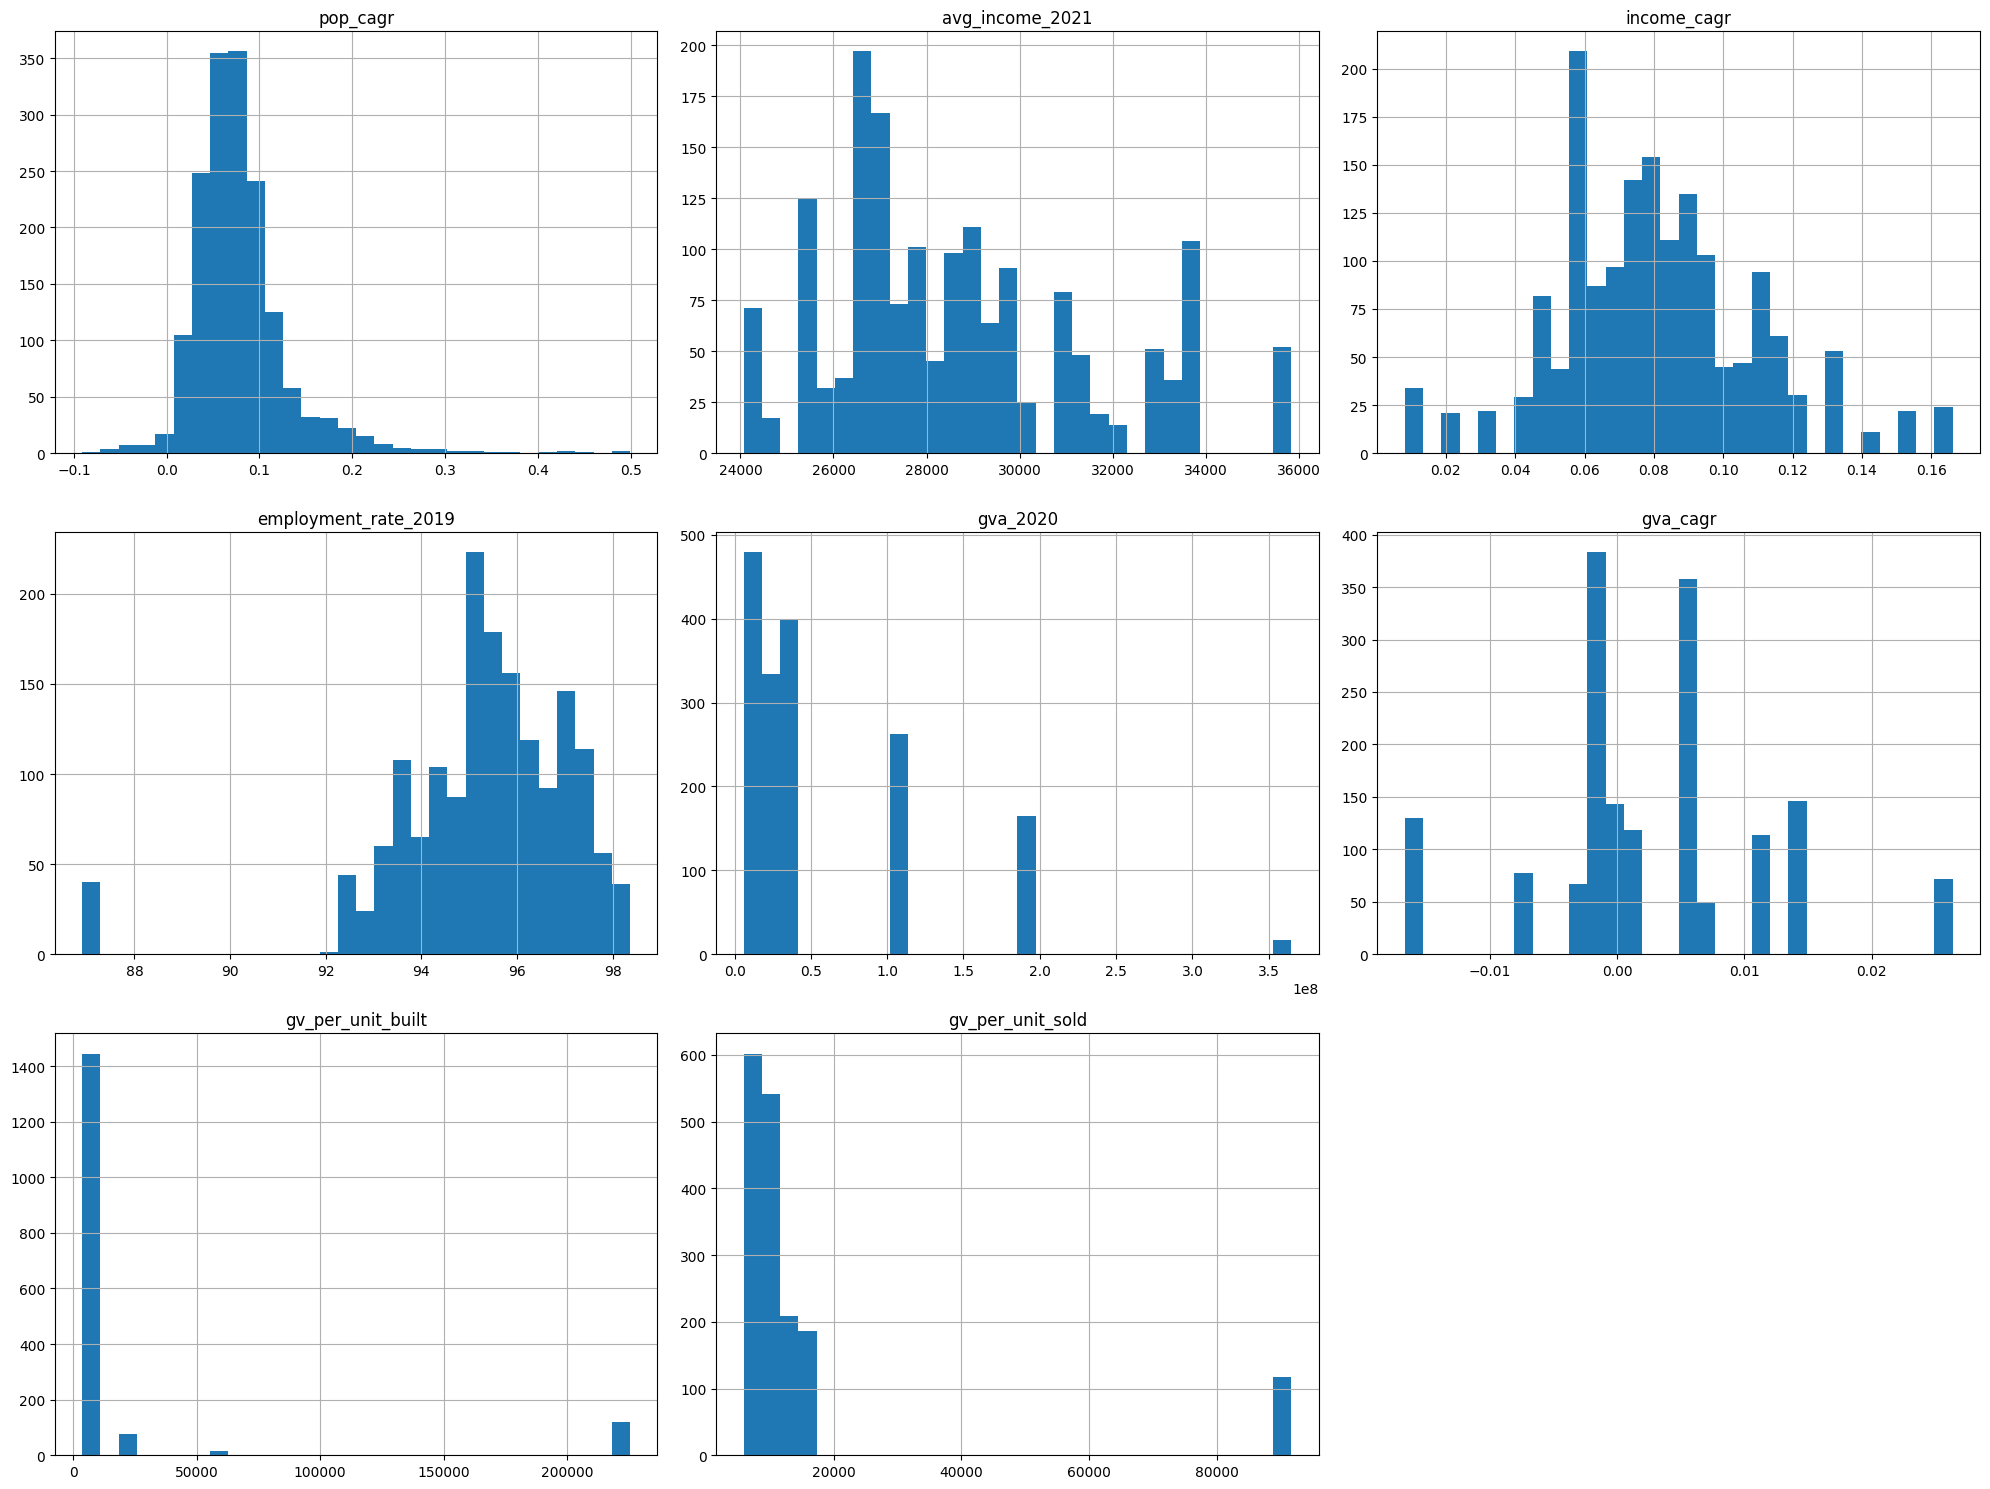

In [57]:
df5.hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

### Opportunity scoring through MCDA

In [58]:
df_scale = df5.copy()

In [60]:
df_scale.rename(columns={'no_of_branches': 'jollibee_branches'}, inplace=True)

In [61]:
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# List of numerical columns to standardize
numerical_columns = ['pop_cagr', 'avg_income_2021', 'income_cagr', 'employment_rate_2019',
                     'gva_2020', 'gva_cagr', 'gv_per_unit_built', 'gv_per_unit_sold','jollibee_branches']

# Standardize the numerical columns
df_scale[numerical_columns] = scaler.fit_transform(df_scale[numerical_columns])

# Display the first few rows of the dataset to confirm standardization
df_scale.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019,gva_2020,gva_cagr,gv_per_unit_built,gv_per_unit_sold,jollibee_branches
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,2.222586,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,1.763068,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,1.002610
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,1.121114,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.557976,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,2.172520,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986


In [62]:
weights = {
    'pop_cagr': 0.1,
    'avg_income_2021': 0.2,
    'income_cagr': 0.2,
    'employment_rate_2019': 0.1,
    'gva_2020': 0.05,
    'gva_cagr': 0.05,
    'gv_per_unit_built': 0.1,
    'gv_per_unit_sold': 0.1,
    'jollibee_branches':0.1
}

# Create a new column 'opportunity_score' by combining the weighted features
df_scale['opportunity_score'] = df_scale[numerical_columns].mul([weights[col] for col in numerical_columns], axis=1).sum(axis=1)

# Display the first few rows of the dataset with the new 'opportunity_score' column
df_scale.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019,gva_2020,gva_cagr,gv_per_unit_built,gv_per_unit_sold,jollibee_branches,opportunity_score
0,mimaropa region,mr-001,palawan,palawan001,bataraza,palawan001bataraza,2.222586,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986,-0.113919
1,mimaropa region,mr-001,palawan,palawan001,puerto-princesa,palawan001puerto-princesa,1.763068,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,1.002610,-0.041711
2,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,1.121114,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986,-0.224066
3,mimaropa region,mr-001,palawan,palawan001,brooke's-point,palawan001brooke's-point,0.557976,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986,-0.280380
4,mimaropa region,mr-001,palawan,palawan001,coron,palawan001coron,2.172520,-1.618363,-0.384206,1.195097,-0.733948,1.27749,-0.344137,-0.300378,-0.178986,-0.118925


In [63]:
top_opportunities = df_scale.sort_values(by='opportunity_score', ascending=False).head(10)
top_opportunities[['region_id', 'province', 'city_municipality', 'opportunity_score']]

,region_id,province,city_municipality,opportunity_score
1236,ncr-001,2nd district,quezon-city,2.821338
1230,ncr-001,1st district,manila,2.550629
1239,ncr-001,2nd district,mandaluyong,1.722598
1093,rvii-001,cebu,cebu,1.549438
1545,barmm-001,sulu,maimbung,1.500453
1544,barmm-001,sulu,patikul,1.482649
1549,barmm-001,sulu,tongkil,1.463046
1540,barmm-001,sulu,pata,1.427123
1551,barmm-001,sulu,omar,1.406629
424,riv-a-001,cavite,trece-martires,1.381966


### Exporting data to local or back to BQ

In [64]:
df_scale_final = df_scale[['region_id','provincial_id','city_municipality_id','opportunity_score']]
df_scale_final.head()

,region_id,provincial_id,city_municipality_id,opportunity_score
0,mr-001,palawan001,palawan001bataraza,-0.113919
1,mr-001,palawan001,palawan001puerto-princesa,-0.041711
2,mr-001,palawan001,palawan001balabac,-0.224066
3,mr-001,palawan001,palawan001brooke's-point,-0.280380
4,mr-001,palawan001,palawan001coron,-0.118925


In [67]:
df_final = pd.merge(df5,df_scale_final, on=(['region_id','provincial_id','city_municipality_id']), how='left')

In [69]:
summary = df_final.describe()
summary.transpose()

,count,mean,std,min,25%,50%,75%,max
pop_cagr,1703.0,0.081524,0.057969,-0.091005,0.048625,0.071561,0.098668,0.49935
avg_income_2021,1703.0,28888.704639,3016.955312,24066.0,26692.0,28270.0,30828.0,35843.0
income_cagr,1703.0,0.08118,0.028552,0.008154,0.060436,0.078623,0.094996,0.166162
employment_rate_2019,1703.0,95.246557,1.911092,86.90916,94.21929,95.40103,96.45679,98.36604
gva_2020,1703.0,61442483.747504,66160107.836881,5863829.0,16978053.0,37823959.0,105893599.0,364799686.0
gva_cagr,1703.0,0.002437,0.009088,-0.016679,-0.001706,0.001122,0.006095,0.02636
gv_per_unit_built,1703.0,23678.903597,55431.058413,3591.336783,6312.954413,7884.854728,9182.170967,225531.884615
gv_per_unit_sold,1703.0,15798.542996,20888.796873,5905.123507,8016.274864,10171.859545,14263.68521,91622.328125
opportunity_score,1703.0,0.019776,0.458998,-0.80282,-0.327477,-0.085542,0.219611,2.821338


In [70]:
df_final['region'].unique()

array(['mimaropa region', 'region xiii (caraga)',
       'region v (bicol region)', 'region i (ilocos region)',
       'region iv-a (calabarzon)', 'region xi (davao region)',
       'region xii (soccsksargen)', 'region ii (cagayan valley)',
       'region iii (central luzon)', 'region vi (western visayas)',
       'region vii (central visayas)', 'region x (northern mindanao)',
       'national capital region (ncr)', 'region viii (eastern visayas)',
       'region ix (zamboanga peninsula)',
       'cordillera administrative region (car)',
       'bangsamoro autonomous region in muslim mindanao (barmm)'],
      dtype=object)

In [71]:
region_mapping = {
    'cordillera administrative region (car)': 'CAR',
    'bangsamoro autonomous region in muslim mindanao (barmm)': 'BARMM',
    'region ix (zamboanga peninsula)': 'region ix (zamboanga)',
    'national capital region (ncr)': 'NCR'
}

df_final['region'] = df_final['region'].replace(region_mapping)


In [72]:
df_final[df_final['region']=='BARMM']

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,pop_cagr,avg_income_2021,income_cagr,employment_rate_2019,gva_2020,gva_cagr,gv_per_unit_built,gv_per_unit_sold,no_of_branches,opportunity_score
1585,BARMM,barmm-001,sulu,sulu001,hadji-panglima-tahil,sulu001hadji-panglima-tahil-,0.104419,31782.0,0.111977,97.40735,5863829,0.001122,225531.884615,91622.328125,0,1.242245
1586,BARMM,barmm-001,sulu,sulu001,pata,sulu001pata,0.203496,31782.0,0.111977,97.40735,5863829,0.001122,225531.884615,91622.328125,0,1.427123
1587,BARMM,barmm-001,sulu,sulu001,luuk,sulu001luuk,0.110101,31782.0,0.111977,97.40735,5863829,0.001122,225531.884615,91622.328125,0,1.252849
1588,BARMM,barmm-001,sulu,sulu001,parang,sulu001parang,0.0678,31782.0,0.111977,97.40735,5863829,0.001122,225531.884615,91622.328125,0,1.173915
1589,BARMM,barmm-001,sulu,sulu001,siasi,sulu001siasi,0.084429,31782.0,0.111977,97.40735,5863829,0.001122,225531.884615,91622.328125,0,1.204943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,BARMM,barmm-001,lanao del sur,lana-d-s001,malabang,lana-d-s001malabang,0.102896,29083.0,0.059966,86.90916,5863829,0.001122,225531.884615,91622.328125,0,0.138527
1699,BARMM,barmm-001,lanao del sur,lana-d-s001,maguing,lana-d-s001maguing,0.138826,29083.0,0.059966,86.90916,5863829,0.001122,225531.884615,91622.328125,0,0.205571
1700,BARMM,barmm-001,lanao del sur,lana-d-s001,taraka,lana-d-s001taraka,0.09611,29083.0,0.059966,86.90916,5863829,0.001122,225531.884615,91622.328125,0,0.125864
1701,BARMM,barmm-001,lanao del sur,lana-d-s001,buadiposo-buntong,lana-d-s001buadiposo-buntong,0.07456,29083.0,0.059966,86.90916,5863829,0.001122,225531.884615,91622.328125,0,0.085652


In [73]:
df_map.head()

,region,region_id,province,provincial_id,city_municipality,city_municipality_id,lat,long
1,mimaropa region,mr-001,palawan,palawan001,balabac,palawan001balabac,7.98,117.050
2,mimaropa region,mr-001,palawan,palawan001,kalayaan,palawan001kalayaan,11.05,114.283
3,mimaropa region,mr-001,palawan,palawan001,aborlan,palawan001aborlan,9.43,118.550
4,mimaropa region,mr-001,palawan,palawan001,sofronio-española,palawan001sofronio-española,9.05,118.033
5,mimaropa region,mr-001,palawan,palawan001,rizal,palawan001rizal,8.68,117.350


In [76]:
df_map_final = df_map[['city_municipality_id','lat','long']]

In [77]:
df_final = pd.merge(df_final,df_map_final, on=(['city_municipality_id']), how='left')

In [78]:
summary = df_final.describe()
summary.transpose()

,count,mean,std,min,25%,50%,75%,max
pop_cagr,1703.0,0.081524,0.057969,-0.091005,0.048625,0.071561,0.098668,0.49935
avg_income_2021,1703.0,28888.704639,3016.955312,24066.0,26692.0,28270.0,30828.0,35843.0
income_cagr,1703.0,0.08118,0.028552,0.008154,0.060436,0.078623,0.094996,0.166162
employment_rate_2019,1703.0,95.246557,1.911092,86.90916,94.21929,95.40103,96.45679,98.36604
gva_2020,1703.0,61442483.747504,66160107.836881,5863829.0,16978053.0,37823959.0,105893599.0,364799686.0
gva_cagr,1703.0,0.002437,0.009088,-0.016679,-0.001706,0.001122,0.006095,0.02636
gv_per_unit_built,1703.0,23678.903597,55431.058413,3591.336783,6312.954413,7884.854728,9182.170967,225531.884615
gv_per_unit_sold,1703.0,15798.542996,20888.796873,5905.123507,8016.274864,10171.859545,14263.68521,91622.328125
opportunity_score,1703.0,0.019776,0.458998,-0.80282,-0.327477,-0.085542,0.219611,2.821338
lat,1703.0,12.063028,3.655635,-33.45,9.17,11.98,14.70179,20.77


In [ ]:
# df_final = df_scale.copy()

In [ ]:
# from google.colab import files

# df_final.to_csv('df_scoring.csv', index=False)
# files.download('df_scoring.csv')

In [ ]:
# file_path = "/Users/fuente/Documents/real_estate_ph_scoring/df_final.csv"
# df_final.to_csv(file_path, index=False)

In [ ]:
# pip install --upgrade nbformat

In [ ]:
# pip install --upgrade plotly pandas numpy

In [ ]:
# pip install folium

In [79]:
import pandas as pd
import folium

# Create a simple DataFrame with made-up data
data = {
    'city_municipality': ['City1', 'City2', 'City3'],
    'lat': [14.5995, 13.0827, 12.8797],
    'lon': [120.9842, 80.2707, 121.7740],
    'opportunity_score': [0.5, 0.7, 0.9],
}

df_sample = pd.DataFrame(data)

# Create a map centered around the coordinates
m = folium.Map(location=[13.41, 122.56], zoom_start=6)

# Loop through the DataFrame and add each data point to the map as a Marker
for idx, row in df_sample.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"City: {row['city_municipality']}, Score: {row['opportunity_score']}",
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(m)

# Display the map
m


In [85]:
import folium
import pandas as pd
from folium.plugins import HeatMap
from IPython.display import display


# Create a base map zoomed to the Philippines
m = folium.Map(location=[df_final['lat'].mean(), df_final['long'].mean()], zoom_start=6)  # Adjust the zoom level here

# Create a custom gradient for the heatmap color scheme
gradient = {0.0: 'blue', 0.5: 'lightblue', 0.7: 'orange', 1.0: 'red'}

# Create a heatmap layer based on the opportunity score with the custom gradient
heat_data = [[row['lat'], row['long'], row['opportunity_score']] for index, row in df_final.iterrows()]
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, gradient=gradient).add_to(m)  # Adjust opacity here

# Display the map inline in Jupyter Notebook
display(m)